In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from matplotlib.patches import Patch

In [2]:
# Define some lists we will use later
violent_crime = [
    'AGG ROBBERY/DEADLY WEAPON',
    'ROBBERY BY ASSAULT',
    'AGG ASLT W/MOTOR VEH FAM/DAT V',
    'AGG ASLT STRANGLE/SUFFOCATE',
    'AGG ASSAULT',
    'AGG ASLT ENHANC STRANGL/SUFFOC',
    'RAPE',
    'DEADLY CONDUCT',
    'AGG ASSAULT FAM/DATE VIOLENCE',
    'AGG RAPE OF A CHILD',
    'AGG RAPE',
    'ROBBERY BY THREAT',
    'AGG ROBBERY BY ASSAULT',
    'RAPE OF A CHILD',
    'AGG ASSAULT WITH MOTOR VEH',
    'MURDER',
    'AGG ASSAULT ON PUBLIC SERVANT',
    'DEADLY CONDUCT FAM/DATE VIOL',
    'MANSLAUGHTER'
]

In [3]:
# Import datasets
austin_crime = pd.read_csv('data/crime-housing-austin-2015.csv')
austin_weather = pd.read_csv('data/austin_weather.csv')
population_data = pd.read_csv('data/AustinZipCodes.csv')

percentage_columns = [
    'Populationbelowpovertylevel', 'Non-WhiteNon-HispanicorLatino', 
    'HispanicorLatinoofanyrace', 'Populationwithdisability', 'Unemployment',
    'Largehouseholds(5+members)', 'Homesaffordabletopeopleearninglessthan$50000',
    'Rentalsaffordabletopeopleearninglessthan$25000', 'Rent-restrictedunits',
    'HousingChoiceVoucherholders', 'Percentageofrentalunitsinpoorcondition',
    'Percentchangeinnumberofhousingunits2000-2012',
    'Changeinpercentageofpopulationbelowpoverty2000-2012',
    'Changeinmedianrent2000-2012', 'Changeinmedianhomevalue2000-2012',
    'Percentageofhomeswithin1/4-mioftransitstop',
    'Percentageofhousingandtransportationcoststhatistransportation-related'
]

currency_columns = ['Medianhouseholdincome', 'Medianrent', 'Medianhomevalue', 'Averagemonthlytransportationcost']

# Setup some functions to convert percentages and currency to floats
def percentage_to_float(value):
    try:
        return float(value.strip('%')) / 100
    except:
        return value

def currency_to_float(value):
    try:
        return float(value.replace('$', '').replace(',', ''))
    except:
        return value
    
# Process data for analysis
for col in percentage_columns:
    austin_crime[col] = austin_crime[col].apply(percentage_to_float)

for col in currency_columns:
    austin_crime[col] = austin_crime[col].apply(currency_to_float)

In [4]:
# Merge crime and weather data, get a daily high and low temperature for each crime
high_low_temp = austin_weather.groupby('Date').agg({'TempHighF': 'max', 'TempLowF': 'min'}).reset_index()

# Convert the date to a datetime object, for high_low_temp and austin_crime
high_low_temp['Date'] = pd.to_datetime(high_low_temp['Date'])
austin_crime['Report_Date'] = pd.to_datetime(austin_crime['Report_Date'])

# Merge the two dataframes
austin_crime = austin_crime.merge(high_low_temp, left_on='Report_Date', right_on='Date')

/tmp/ipykernel_1194494/2058581474.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  austin_crime['Report_Date'] = pd.to_datetime(austin_crime['Report_Date'])


In [5]:
# Filter the merged data for crime, date, and high and low temperature
crime_temp = austin_crime[['Highest_Offense_Desc', 'Zip_Code_Crime', 'Report_Date', 'TempHighF', 'TempLowF', 'Populationbelowpovertylevel']]

In [6]:
# Get a list of zip code for areas with more than 20% of population below the poverty level
poverty = austin_crime[austin_crime['Populationbelowpovertylevel'] > 0.2].dropna()
poverty_zips = poverty['Zip_Code_Crime'].unique()

In [7]:
# With the new poverty zips, add a column boolean for poverty_zip
crime_temp['Poverty_Zip'] = crime_temp['Zip_Code_Crime'].apply(lambda x: x in poverty['Zip_Code_Crime'].unique())

/tmp/ipykernel_1194494/4106168296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_temp['Poverty_Zip'] = crime_temp['Zip_Code_Crime'].apply(lambda x: x in poverty['Zip_Code_Crime'].unique())


19


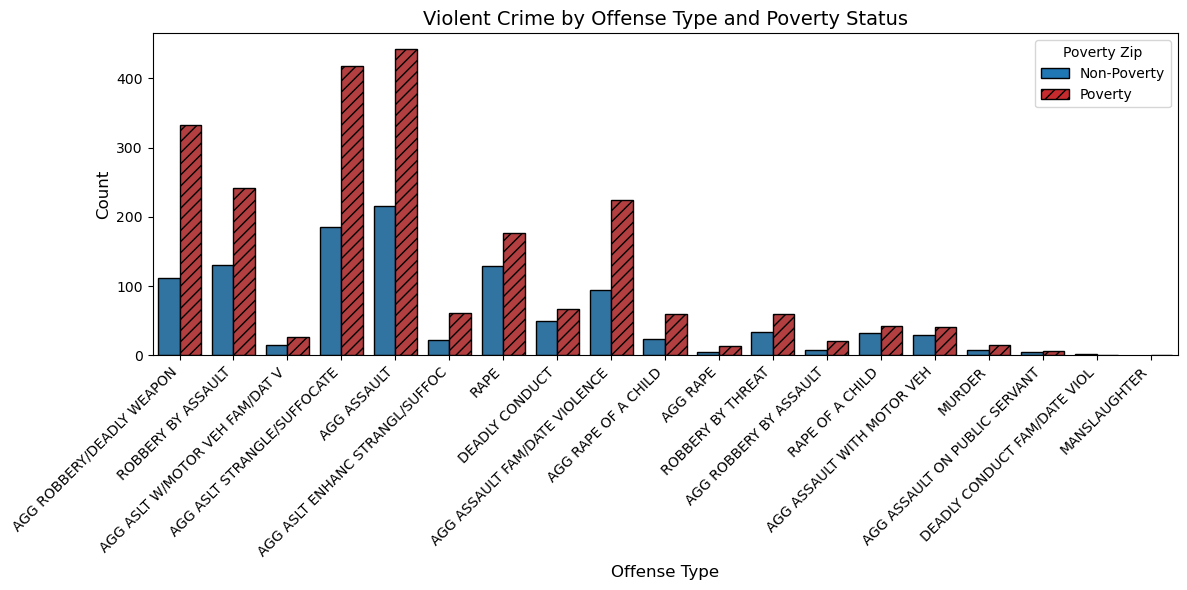

In [8]:
# Aggregate the Highest_Offense_Desc by poverty zip, compare crime in poverty zips by non-poverty zips
crime_poverty = crime_temp.groupby('Poverty_Zip')['Highest_Offense_Desc'].value_counts()

just_v_crime = crime_temp[crime_temp['Highest_Offense_Desc'].isin(violent_crime)]

# Create the countplot
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Highest_Offense_Desc', hue='Poverty_Zip', data=just_v_crime,
                   hue_order=[False, True],
                   palette=['#1f77b4', '#c82b2e'],
                   edgecolor='black')

# Apply hatch pattern to all poverty bars
n_bars = len(ax.patches) // 2
print(n_bars)
for i in range(n_bars - 1, len(ax.patches)):
    ax.patches[i].set_hatch('///')

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Offense Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Violent Crime by Offense Type and Poverty Status', fontsize=14)

# Setup legend
legend_elements = [Patch(facecolor='#1f77b4', edgecolor='black', label='Non-Poverty'),
                   Patch(facecolor='#c82b2e', edgecolor='black', hatch='///', label='Poverty')]

plt.legend(handles=legend_elements, title='Poverty Zip', loc='upper right')
plt.tight_layout()

# plt.savefig('plots/violent_crime_by_poverty_status.png')
plt.show()